<a href="https://colab.research.google.com/github/infiniteoverflow/CIFAR10-Classification/blob/master/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR10 Dataset

We will be working with the CIFAR10 Dataset to perform image classification using CNN. The images in the database are small color images that fall into one of 10 classes.  
<br>


<p align="center">
  <img width="460" height="400" src="https://storage.googleapis.com/kaggle-competitions/kaggle/3649/media/cifar-10.png">
</p>


## Check for GPU

In [2]:
import numpy as np
import torch

train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
  print("GPU is available")
else:
  print("GPU is not available")

GPU is available


## Loading the dataset

In [0]:
from torchvision import datasets,transforms
from torch import nn
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.optim as optim
import time

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                ])

trainset = datasets.CIFAR10('/tmp/cifar-train',train=True,transform=transform,download=True)
testset = datasets.CIFAR10('/tmp/cifar-test',train=False,transform=transform,download=True)

Extracting /tmp/cifar-train/cifar-10-python.tar.gz to /tmp/cifar-train


Extracting /tmp/cifar-test/cifar-10-python.tar.gz to /tmp/cifar-test


In [0]:
num_workers = 0

batch_size = 20

valid_size = 0.2

num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)

split = int(np.floor(valid_size*num_train))

train_idx,valid_idx = indices[split:] , indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(valid_idx)

In [0]:
train_loader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,sampler=train_sampler)

validation_loader = torch.utils.data.DataLoader(trainset,batch_size,sampler=validation_sampler)

test_loader = torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle = True)

In [12]:
dataiter = iter(train_loader)
images , labels = next(dataiter)

images.shape

torch.Size([20, 3, 32, 32])

**So the image size is 32x32 with 3 channels**

In [13]:
dataiter = iter(validation_loader)
images , labels = next(dataiter)

images.shape

torch.Size([20, 3, 32, 32])

In [14]:
dataiter = iter(test_loader)
images , labels = next(dataiter)

images.shape

torch.Size([20, 3, 32, 32])

## Visualize a batch of images

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

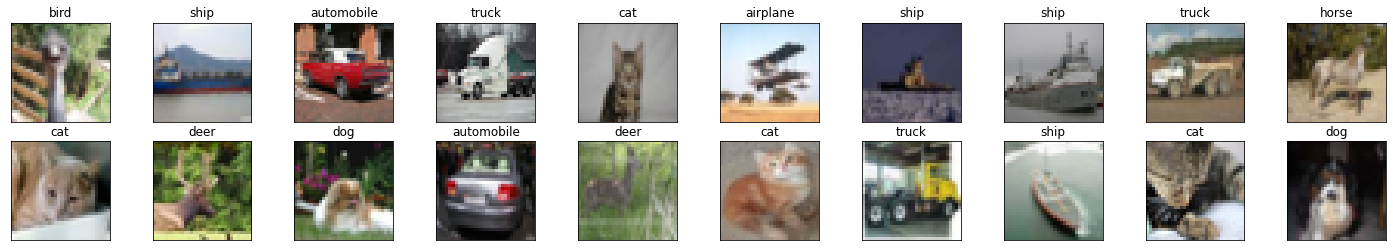

In [17]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## View an image in more detail

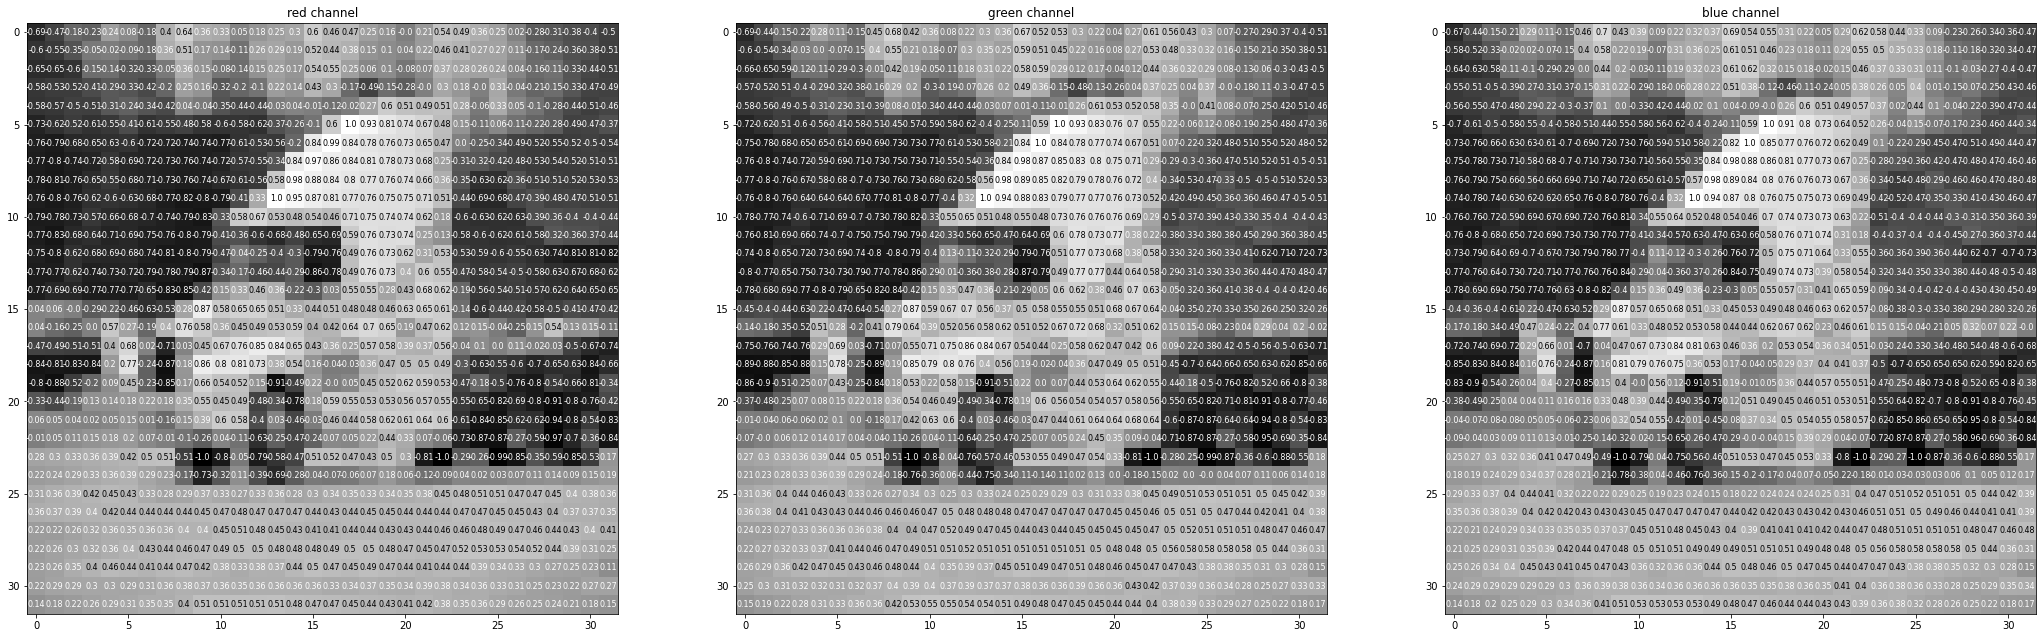

In [18]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

## Defining the CNN Architecture

In [0]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3,16,3,padding=1)

    self.conv2 = nn.Conv2d(16,32,3,padding=1)

    self.conv3 = nn.Conv2d(32,64,3,padding=1)

    self.pool = nn.MaxPool2d(2,2)

    self.fc1 = nn.Linear(64*4*4,512)

    self.fc2 = nn.Linear(512,256)

    self.output = nn.Linear(256,10)

    self.dropout = nn.Dropout(0.2)

  def forward(self,x):

    x = self.pool(F.relu(self.conv1(x)))

    x = self.pool(F.relu(self.conv2(x)))

    x = self.pool(F.relu(self.conv3(x)))

    x = x.view(-1,64*4*4)

    x = self.dropout(x)

    x = F.relu(self.fc1(x))

    x = self.dropout(x)

    x = F.relu(self.fc2(x))

    x = self.dropout(x)

    x = F.relu(self.output(x)) 

    return x

In [55]:
model = Network()

if train_on_gpu:
  model.cuda()

model

Network(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

## Training and validating the Neural Network

In [56]:
epochs = 30

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(),lr=0.01)

t_loss , v_loss = [] , []

valid_loss_min = np.inf

for epoch in range(epochs):
  trainloss , validationloss = 0 , 0

  start = time.time()

  model.train()

  for image,label in train_loader:

    if train_on_gpu:
      image , label = image.cuda(),label.cuda()

    optimizer.zero_grad()

    output = model(image)

    loss = criterion(output,label)

    loss.backward()

    optimizer.step()

    trainloss += loss.item()*image.size(0)

  model.eval()

  for image,label in validation_loader:

    if train_on_gpu:
      image , label = image.cuda(),label.cuda()

    output = model(image)

    loss = criterion(output,label)

    

    validationloss += loss.item()*image.size(0)

  trainloss = trainloss/(len(train_loader.dataset))
  validationloss = validationloss/(len(validation_loader.dataset))

  t_loss.append(trainloss)
  v_loss.append(validationloss)

  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \t Time taken:{:.2f} s'.format(
        epoch, trainloss, validationloss,(time.time() - start)))
    
    # save model if validation loss has decreased
  if validationloss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
    valid_loss_min,
    validationloss))
    torch.save(model.state_dict(), 'model_cifar.pt')
    valid_loss_min = validationloss


Epoch: 0 	Training Loss: 1.819505 	Validation Loss: 0.426247 	 Time taken:26.08 s
Validation loss decreased (inf --> 0.426247).  Saving model ...
Epoch: 1 	Training Loss: 1.592444 	Validation Loss: 0.357986 	 Time taken:26.38 s
Validation loss decreased (0.426247 --> 0.357986).  Saving model ...
Epoch: 2 	Training Loss: 1.368314 	Validation Loss: 0.310278 	 Time taken:26.32 s
Validation loss decreased (0.357986 --> 0.310278).  Saving model ...
Epoch: 3 	Training Loss: 1.237481 	Validation Loss: 0.284593 	 Time taken:26.31 s
Validation loss decreased (0.310278 --> 0.284593).  Saving model ...
Epoch: 4 	Training Loss: 1.144962 	Validation Loss: 0.264951 	 Time taken:26.28 s
Validation loss decreased (0.284593 --> 0.264951).  Saving model ...
Epoch: 5 	Training Loss: 1.064857 	Validation Loss: 0.242568 	 Time taken:26.25 s
Validation loss decreased (0.264951 --> 0.242568).  Saving model ...
Epoch: 6 	Training Loss: 0.989943 	Validation Loss: 0.224716 	 Time taken:26.26 s
Validation loss d

## Visualizing the train and validation loss

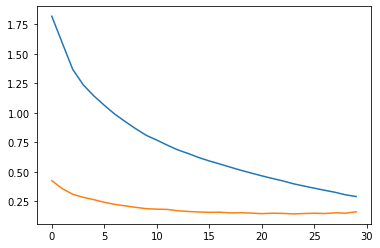

In [57]:
import matplotlib.pyplot as plt

ax = plt.plot(t_loss)

plt.plot(v_loss)

plt.show()

# Loading the saved model

In [58]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

# Testing the model

In [59]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.730677

Test Accuracy of airplane: 73% (736/1000)
Test Accuracy of automobile: 86% (868/1000)
Test Accuracy of  bird: 60% (606/1000)
Test Accuracy of   cat: 61% (617/1000)
Test Accuracy of  deer: 71% (710/1000)
Test Accuracy of   dog: 64% (643/1000)
Test Accuracy of  frog: 85% (851/1000)
Test Accuracy of horse: 75% (750/1000)
Test Accuracy of  ship: 89% (893/1000)
Test Accuracy of truck: 83% (832/1000)

Test Accuracy (Overall): 75% (7506/10000)
